In [1]:
import os
import math
import pandas as pd
import datetime as dt
import matplotlib.pylab as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
from pandas.api.types import CategoricalDtype
from dateutil.relativedelta import relativedelta
from IPython.display import display


BASE_DIR = os.getcwd()
DATA_FP = os.path.join(BASE_DIR, 'loan.csv')

EARLIEST_ISSUE = dt.date(2007,6,1)
LAST_PAYMENT_DATE = dt.date(2016,1,1)
pd.options.display.max_columns = 999



In [2]:
raw_data = pd.read_csv(DATA_FP, low_memory=False)

emp_title
51462


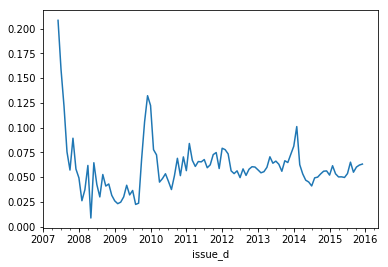

emp_length
44825


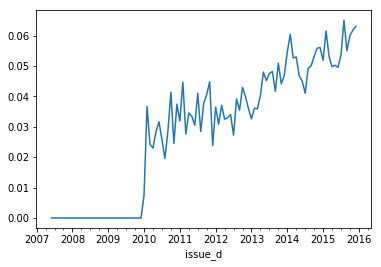

annual_inc
4


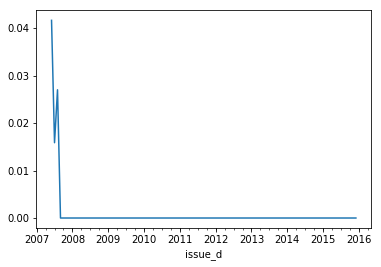

desc
761351


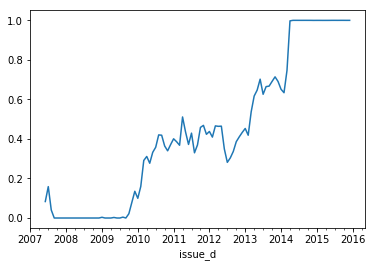

title
152


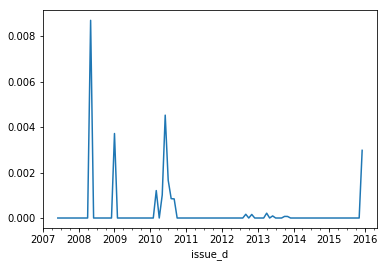

delinq_2yrs
29


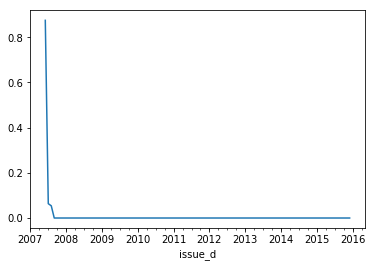

earliest_cr_line
29


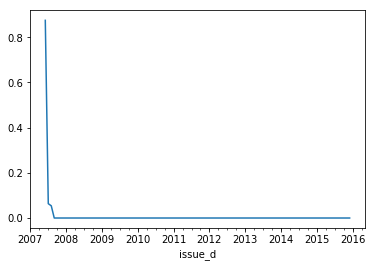

inq_last_6mths
29


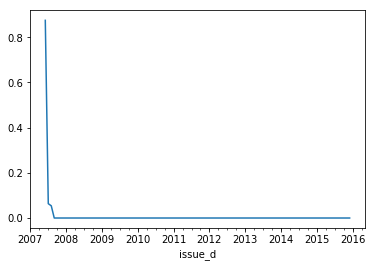

mths_since_last_delinq
454312


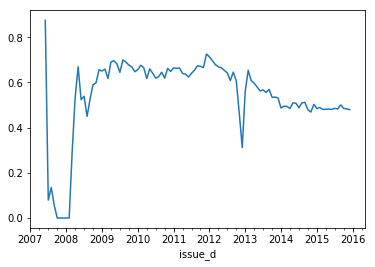

mths_since_last_record
750326


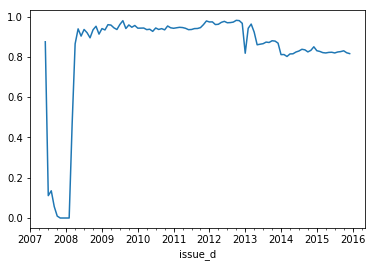

open_acc
29


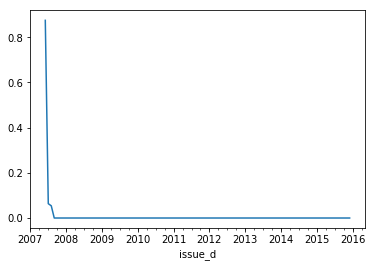

pub_rec
29


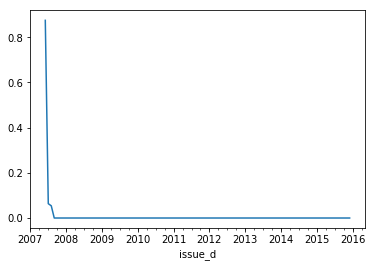

revol_util
502


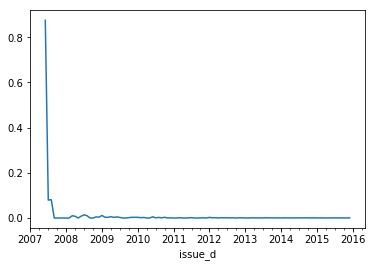

total_acc
29


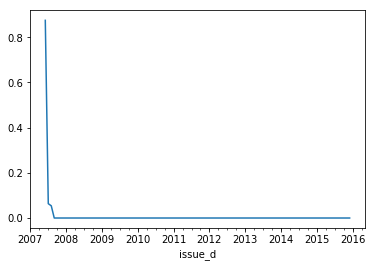

last_pymnt_d
17659


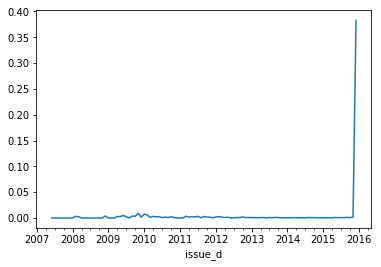

next_pymnt_d
252971


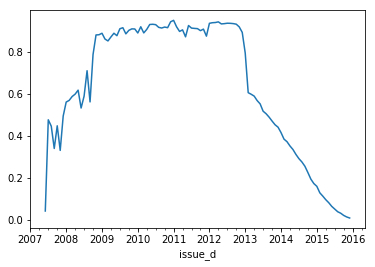

last_credit_pull_d
53


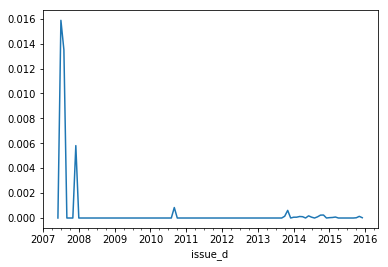

collections_12_mths_ex_med
145


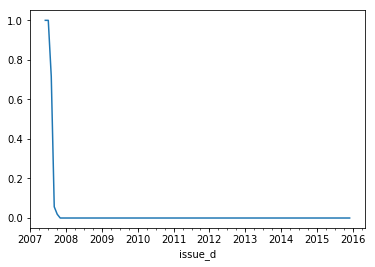

mths_since_last_major_derog
665676


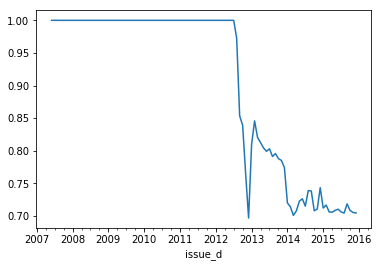

annual_inc_joint
886868


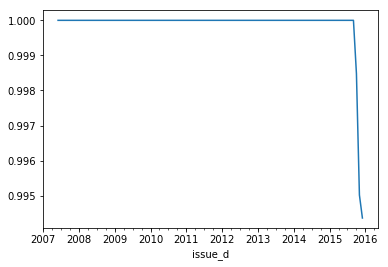

dti_joint
886870


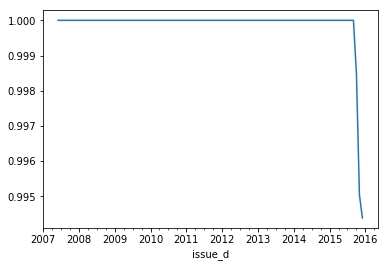

verification_status_joint
886868


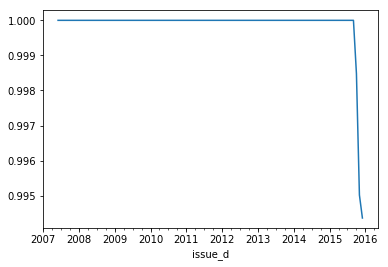

acc_now_delinq
29


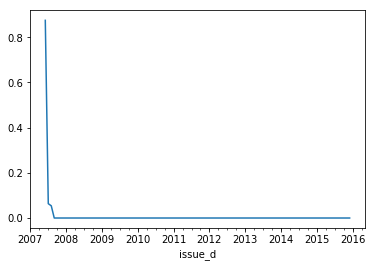

tot_coll_amt
70276


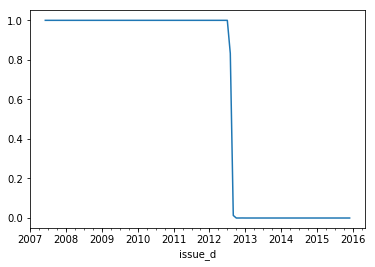

tot_cur_bal
70276


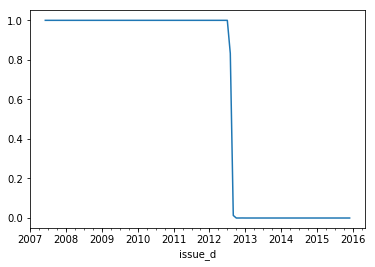

open_acc_6m
866007


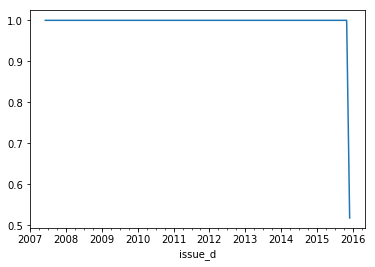

open_il_6m
866007


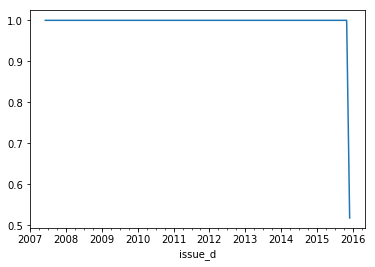

open_il_12m
866007


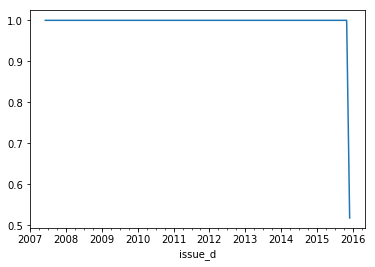

open_il_24m
866007


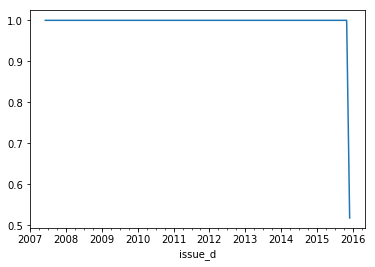

mths_since_rcnt_il
866569


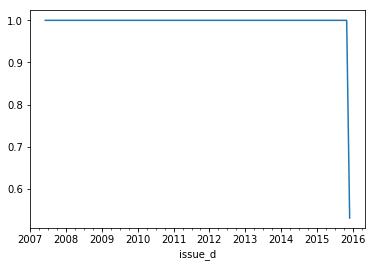

total_bal_il
866007


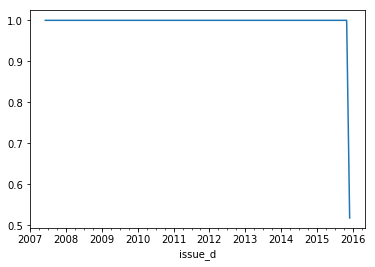

il_util
868762


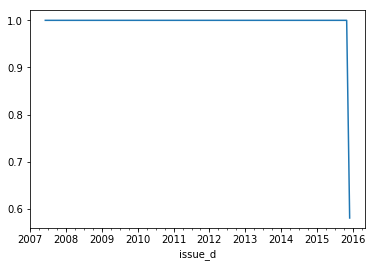

open_rv_12m
866007


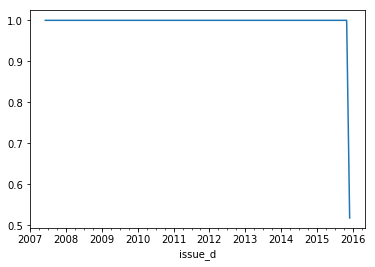

open_rv_24m
866007


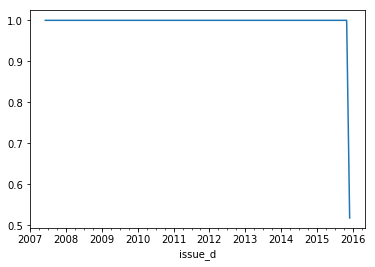

max_bal_bc
866007


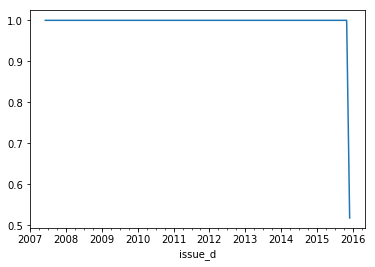

all_util
866007


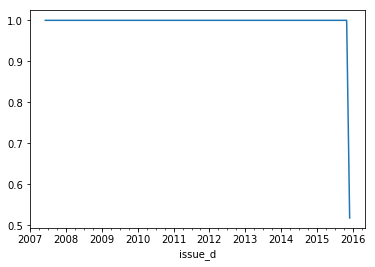

total_rev_hi_lim
70276


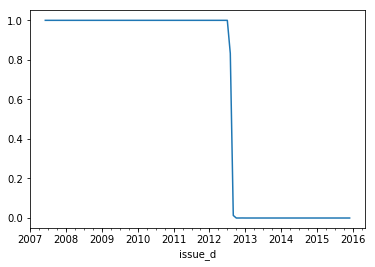

inq_fi
866007


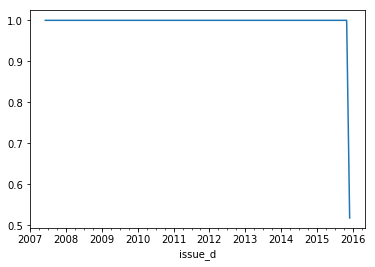

total_cu_tl
866007


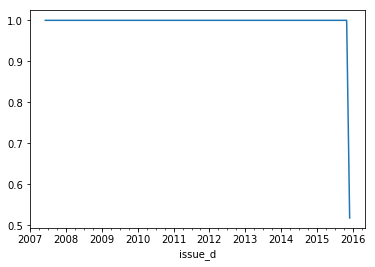

inq_last_12m
866007


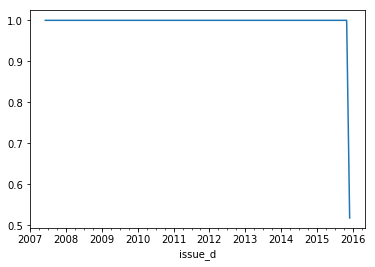

In [3]:
def NaN_over_time(df):
    '''
    for columns with missing values its useful to examine how they are distributed
    with respect to time.  Here we plot, percentage of records with null values over issue date.
    '''
    df.issue_d = pd.to_datetime(df.issue_d, format="%b-%Y")
    df = df.set_index(df.issue_d)
    for column in df.columns:
        s = df[column]
        if(s.isnull().sum() > 0):
            print(column)
            print(s.isnull().sum())
            s.groupby(s.index).apply(lambda x: 1 if x.size == 0 else x.isnull().sum() / x.size).plot()
            plt.show()


NaN_over_time(raw_data)

In [4]:
def delete_cols(df):
    
    # drop id and member_id columns - each is unique in this dataset
    df = df.drop(['id', 'member_id'], axis=1)
    
    # potentially useful and interesting data, but NLP outof scope for initial modeling
    df = df.drop(['emp_title', 'title', 'desc', 'url'], axis =1)
    
    # drop 4 records with no annual income information
    df = df[~(df.annual_inc.isnull())]

    # there are 29 early loans that lack a lot of information drop these rows
    df = df[~(df.delinq_2yrs.isnull())]
    df = df[~(df.earliest_cr_line.isnull())]
    df = df[~(df.inq_last_6mths.isnull())]
    df = df[~(df.open_acc.isnull())]
    df = df[~(df.pub_rec.isnull())]
    df = df[~(df.total_acc.isnull())]
        
    # drop 'mths_since_last_record' and 'mths_since_last_major_derog'.  
    # These columns are null for ~85% of records and are distributed strangly
    # w.r.t time.  indicating, lending club changed their data collection practices
    df = df.drop(['mths_since_last_record', 'mths_since_last_major_derog'], axis=1)
    
    # looking at the distributions of missing values w.r.t time shows that lending club
    # added many new data-elements in 2013 and 2015, these are unsuitable for modeling.
    df = df.drop(['annual_inc_joint', 'dti_joint', 'verification_status_joint',
                  'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 
                 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
                 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
                  'inq_last_12m'
                 ], axis=1)
    
    # these columns are binary-valued with over 99.9% of records taking the more common value.
    df = df.drop(['pymnt_plan', 'application_type', 'policy_code'], axis=1)
    return df

print (raw_data.shape)
data = delete_cols(raw_data)
print (data.shape)

(887379, 74)
(887350, 43)


In [5]:
def transform(df):
    
    #convert term to int: duration in months
    df.term = df.term.apply(lambda x : int(x.split(" ")[1]))

    # add column flagging were employement length was imputed
    df['emp_length_imp'] = df.emp_length.isnull().astype('int')
    
    # convert employemnt length to numeric and imputer missing values with median
    df.emp_length = df.emp_length.replace("< 1 year", "0")
    df.emp_length = df.emp_length.str.extract('(\d+)', expand=False)
    df.emp_length = df.emp_length.fillna(df.emp_length.median()).astype('int')
    
    # for records that havent had delinquencies fill NaNs with large value 9999
    df.mths_since_last_delinq = df.mths_since_last_delinq.fillna(9999)
    
    df.revol_util = df.revol_util.fillna(df.revol_util.median())
    df.collections_12_mths_ex_med = df.collections_12_mths_ex_med.fillna(df.collections_12_mths_ex_med.mode()[0])

    #convert to categorical
    grade_cats = CategoricalDtype(categories=['G', 'F', 'E', 'D', 'C', 'B',
                                              'A'], ordered=True) 
    df.grade = df.grade.astype(grade_cats)
    sub_grade_cats = CategoricalDtype(categories=[
        'G5', 'G4', 'G3', 'G2', 'G1',
        'F5', 'F4', 'F3', 'F2', 'F1',
        'E5', 'E4', 'E3', 'E2', 'E1',
        'D5', 'D4', 'D3', 'D2', 'D1',
        'C5', 'C4', 'C3', 'C2', 'C1',
        'B5', 'B4', 'B3', 'B2', 'B1',
        'A5', 'A4', 'A3', 'A2', 'A1',
    ], ordered=True)
    df.sub_grade = df.sub_grade.astype(sub_grade_cats)
    
    categorical_cols = [
        'home_ownership', 'verification_status', 'loan_status', 'purpose', 
        'zip_code', 'addr_state', 'initial_list_status'
    ]
    for col in categorical_cols:
        df[col] = df[col].astype("category")

    
    #convert to datetimes
    datetime_cols = [
        'issue_d', 'earliest_cr_line', 'last_pymnt_d',
        'next_pymnt_d', 'last_credit_pull_d'
    ]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], format="%b-%Y")
    df.issue_d = pd.to_datetime(df.issue_d, format="%b-%Y")
    df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format="%b-%Y")
    df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d, format="%b-%Y")

    #NaNs in next payment date column most likely indicate loan has been closed
    df.next_pymnt_d = df.next_pymnt_d.fillna(df.last_pymnt_d)
    
    
    
    # drop 27368 records that were issued on or after 2015-12-1.  Observed issues where
    # lending club's data conflicted - i.e. the "total payment" field wouldn't account for
    # payments they were shown to have made on 2016-1-1.
    df = df[~(df.issue_d >= dt.date(2015,12,1))]
    
    return(df)
    

cleaned_data = transform(data)


In [6]:
def add_features(df):
    
    df['loan_is_open'] = df.loan_status.isin([
        'Current', 'Late (31-120 days)', 'Issued', 
        'In Grace Period', 'Late (16-30 days)', 'Default'
    ])
    
    df['maturity_d'] = df.apply(
        lambda x: x['issue_d'] +pd.DateOffset(years=int((x['term']/12))),
        axis=1)
    
    df['earliest_cr_delta'] = (df.issue_d - df.earliest_cr_line).dt.days
    
    '''
    4 cases for loan duration:
        1) loan is closed, and fully paid
        2) loan is closed, borrower made at least some payments and went through chargeoff process
        3) loan is closed, borrower never made a payment and went through chargeoff process
        3) loan is open
    '''
    df['loan_duration'] = np.nan
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Fully Paid", 
             "Does not meet the credit policy. Status:Fully Paid"
            ]
        )), "loan_duration"
    ] = ((df.last_pymnt_d + pd.offsets.DateOffset(months=1))- df.issue_d).dt.days / 365.0
    
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Charged Off", 
             "Does not meet the credit policy. Status:Charged Off"
            ])) &
         (~df.last_pymnt_d.isnull()), "loan_duration"
    ] = (
        ((df.last_pymnt_d - df.issue_d).dt.days + 180) / 365.0
    )
    
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Charged Off", 
             "Does not meet the credit policy. Status:Charged Off"
            ])) &
         (df.last_pymnt_d.isnull()), "loan_duration"
    ] = 180 / 365.0

    
    df.loc[
        df.loan_is_open, 
        'loan_duration'
    ] = (LAST_PAYMENT_DATE - df.issue_d).dt.days / 365.0
    

    # total revoling credit limit
    df['revol_limit'] = df.revol_bal
    df.loc[df.revol_util != 0, "revol_limit"] = df.revol_bal / (df.revol_util / 100) 
    
    df['avg_revol_acc_limit'] = df.revol_limit
    df.loc[df.open_acc != 0, 'avg_revol_acc_limit'] = df.revol_limit / df.open_acc
    
    df['avg_revol_acc_bal'] = df.revol_bal
    df.loc[df.open_acc != 0, 'avg_revol_acc_bal'] = df.revol_bal / df.open_acc
    
    df['percentage_funded'] = df.funded_amnt_inv / df.loan_amnt
    
    df['inst_to_income'] = 1
    df.loc[df.annual_inc != 0, 'inst_to_income'] = df.installment / df.annual_inc
    
    #calculate raw ROI 
    df['raw_ROI'] = (
        (df.total_pymnt - df.funded_amnt) 
        / df.funded_amnt)
    
    #calculate raw relative yeild
    df['raw_rel_yield'] = 0.0
    
    df.loc[df.loan_is_open, 'raw_rel_yield'] = (
        (df.total_pymnt - df.funded_amnt*((df.loan_duration*12)/df.term))
            / df.funded_amnt*((df.loan_duration*12)/df.term)
    )
    
    df.loc[~(df.loan_is_open), 'raw_rel_yield'] = df.raw_ROI
    
    #calculate ROI / duration
    df['yearly_ROI'] = ((
        (df.total_pymnt - df.funded_amnt) 
        / df.funded_amnt) 
    / np.ceil(df.loan_duration))
        
    #calculate rel_yeild / duration
    df['yearly_rel_yield'] = 0.0
    
    df.loc[df.loan_is_open, 'yearly_rel_yield'] = (
        (
            (df.total_pymnt - df.funded_amnt*((df.loan_duration*12)/df.term))
            / df.funded_amnt*((df.loan_duration*12)/df.term)
        ) / np.ceil(df.loan_duration)
    )
    
    df.loc[~(df.loan_is_open), 'yearly_rel_yield'] = df.yearly_ROI
        
    return df


    

    
enriched_data = add_features(cleaned_data)

/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [7]:
enriched_data.describe(include='all')

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,emp_length_imp,loan_is_open,maturity_d,earliest_cr_delta,loan_duration,revol_limit,avg_revol_acc_limit,avg_revol_acc_bal,percentage_funded,inst_to_income,raw_ROI,raw_rel_yield,yearly_ROI,yearly_rel_yield
count,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008,843008,843008.000000,843008,8.430080e+05,843008,843008,843008,843008,843008,843008,843008.000000,843008.000000,843008,843008.000000,843008.000000,843008.000000,843008.000000,8.430080e+05,843008.000000,843008.000000,843008,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,842323,843008.000000,842481,842957,843008.000000,843008.000000,843008.000000,843008,843008,843008.000000,843008.000000,8.430080e+05,8.430080e+05,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000,843008.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,7,35,NaN,6,NaN,3,102,9,14,932,51,NaN,NaN,694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,NaN,100,103,NaN,NaN,NaN,2,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,B,B3,NaN,MORTGAGE,NaN,Source Verified,2015-10-01 00:00:00,Current,debt_consolidation,945xx,CA,NaN,NaN,2001-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,2016-02-01 00:00:00,2016-01-01 00:00:00,NaN,NaN,NaN,True,2018-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,241164,53452,NaN,421933,NaN,311884,48631,566509,499154,9299,123507,NaN,NaN,6349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443107,NaN,516972,686751,NaN,NaN,NaN,587685,37334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1944-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-01 00:00:00,NaN,2007-12-01 00:00:00,2007-05-01 00:00:00,NaN,NaN,NaN,NaN,2010-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,2016-03-01 00:00:00,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,2020-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,14739.499744,14725.410672,14684.443910,43.181427,13.297522,436.777382,NaN,NaN,6.012681,NaN,7.479997e+04,NaN,NaN,NaN,NaN,NaN,NaN,18.080209,0.312756,NaN,0.699271,5152.705164,11.523392,0.192596,1.688471e+04,55.219546,25.264336,NaN,8069.309095,8066.126468,7936.022022,7896.501208,6044.651140,1842.624250,0.417350,48.329284,5.135256,NaN,2256.806931,NaN,NaN,0.013906,0.004956,0.049860,NaN,NaN,5959.221497,1.212147,3.731054e+04,3.396006e+03,1561.448025,0.995671,0.006662,-0.433948,0.026951,-0.391545,0.006675
std,8419.513798,8413.622561,8426.573795,10.990063,4.384937,243.914976,NaN,NaN,3.569162,NaN,6.242896e+04,NaN,NaN,NaN,NaN,NaN,NaN,13.687262,0.859489,NaN,1.003454,4980.634339,5.294729,0.576686,2.237077e+04,23.799478,11.825292,NaN,8348.860065,8345.634904,7887.916588,7863.341997,6664.071982,2113.459543,4.190745,420.164432,64.727475,NaN,4886.176220,NaN,NaN,0.132294,0.077622,0.217655,NaN,NaN,2721.236359,0.854410,4.420457e+05,5.243599e+04,2053.104466,0.047879,0.003555,0.412198,0.170764,0.391746,0.116845
min,500.000000,500.0000

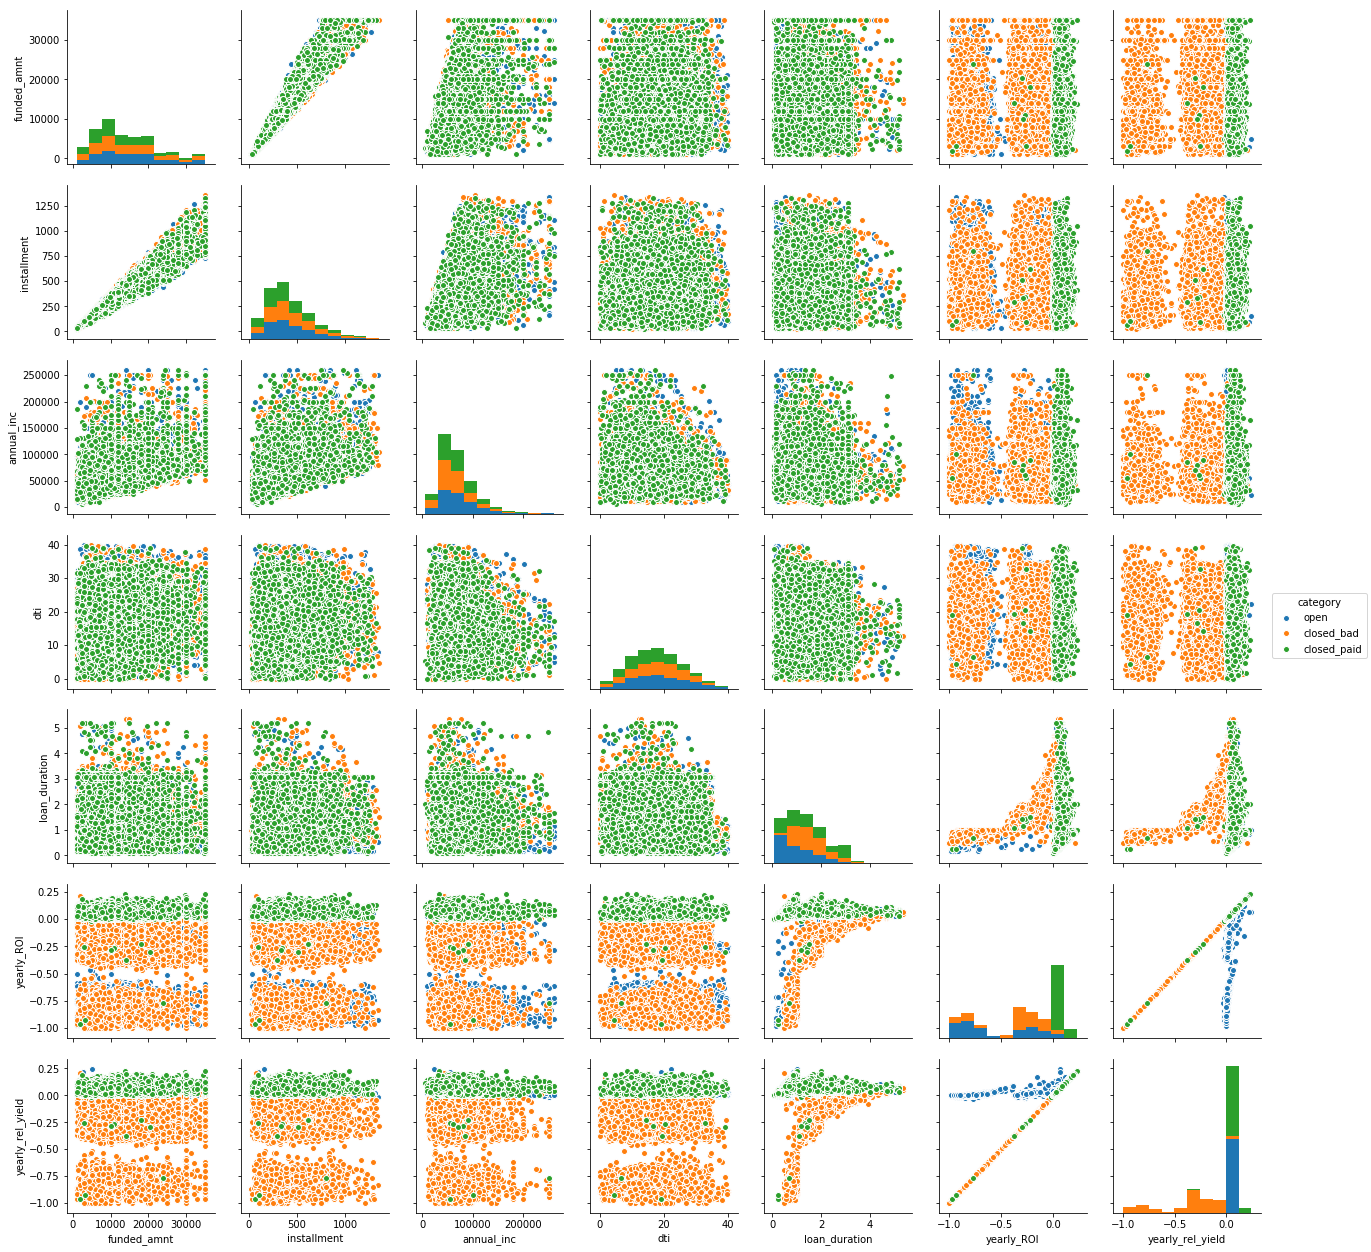

In [8]:
def outliers(df, col_name):
    return (np.abs(df[col_name] -df[col_name].mean()) / df[col_name].std()) >= 3



cont = enriched_data[[
    'funded_amnt',
    'installment',
    'annual_inc',
    'dti',
    'loan_duration',
    'yearly_ROI',
    'loan_is_open',
    'loan_status',
    'yearly_rel_yield'
]]
cont = cont[~outliers(cont, 'annual_inc')]
cont = cont[~outliers(cont, 'dti')]
cont['category'] = ""
cont.loc[cont.loan_is_open, "category"] = "open"
cont.loc[
    (~cont.loan_is_open) & 
    cont.loan_status.isin(
        ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]
    ), "category"] = "closed_paid"
cont.loc[
    (~cont.loan_is_open) & 
    cont.loan_status.isin(
        ["Charged Off", "Does not meet the credit policy. Status:Charged Off"]
    ), "category"] = "closed_bad"

cont = cont.drop(['loan_status', 'loan_is_open'], axis=1)
cont_open = cont[cont.category == 'open'].sample(n=5000, replace=False)
cont_bad = cont[cont.category == 'closed_bad'].sample(n=5000, replace=False)
cont_good = cont[cont.category == 'closed_paid'].sample(n=5000, replace=False)
cont_final = pd.concat([cont_open, cont_bad, cont_good])
g = sns.pairplot(cont_final, hue="category")


In [9]:
def calc_expected_return(df):
    '''
    '''
    df['issue_d_year'] = df.issue_d.dt.year
    df = df[~df.loan_is_open]
    #df['ROI'] = (100*((df.total_pymnt - df.funded_amnt) / df.funded_amnt))/(df.loan_duration)
    mean_list = []
    std_list = []
    for term in [36, 60]:
        for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
            mean_record = {"term":term, "grade": grade}
            std_record = {"term": term, "grade": grade}
            for issue_d in [2007, 2008, 2009, 2010, 2011, 2012]:
                loans = df[(df.grade == grade) &
                           (df.term == term) &
                           (df.issue_d_year == issue_d)
                          ]
                ROI = 100*loans.yearly_ROI.mean()
                ROI_std = 100*loans.yearly_ROI.std()
                #total_funded = loans.funded_amnt.sum()
                #total_return = loans.total_pymnt.sum()
                #ROI = (100*((total_return - total_funded) / total_funded))/(term/12)
                mean_record[str(issue_d)] = round(ROI,2)
                std_record[str(issue_d)] = round(ROI_std, 2)
                #loans.ROI.plot(normed=True)
            #plt.show()
            mean_list.append(mean_record)
            std_list.append(std_record)

    means = pd.DataFrame(mean_list)
    means = means.set_index(['grade', 'term'])
    means['AVG'] = round(means.mean(axis=1),2)
    means['+/-'] = round(means.std(axis=1),2)
    stds = pd.DataFrame(std_list)
    stds = stds.set_index(['grade', 'term'])
    stds['AVG'] = round(stds.mean(axis=1),2)
    stds['+/-'] = round(stds.std(axis=1),2)
    display(means)
    display(stds)
                
calc_expected_return(enriched_data)


/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,,2007,2008,2009,2010,2011,2012,AVG,+/-
grade,term,,,,,,,,
A,36,3.00,2.16,2.18,2.14,1.24,1.30,2.00,0.60
B,36,-2.42,-1.19,0.74,1.81,1.68,1.99,0.44,1.67
C,36,-2.16,-1.75,-0.04,1.54,0.90,1.71,0.03,1.52
D,36,-2.68,-4.04,-0.01,-0.06,1.40,1.79,-0.60,2.10
E,36,-3.81,-2.37,-1.46,0.41,1.08,2.60,-0.59,2.17
F,36,-11.45,-7.03,-1.47,-3.78,1.32,1.40,-3.50,4.60
G,36,-6.98,-3.16,-1.26,-2.32,-1.67,4.87,-1.75,3.51
A,60,NaN,NaN,NaN,1.68,1.68,1.37,1.58,0.15
B,60,NaN,NaN,NaN,0.51,-0.25,-1.30,-0.35,0.74


,,2007,2008,2009,2010,2011,2012,AVG,+/-
grade,term,,,,,,,,
A,36,3.33,8.40,8.29,7.02,9.64,10.99,7.94,2.40
B,36,20.11,17.35,16.68,13.14,13.57,13.63,15.75,2.53
C,36,15.97,18.24,19.87,16.14,17.08,16.72,17.34,1.35
D,36,17.07,22.94,20.03,20.60,17.64,18.88,19.53,1.96
E,36,19.34,21.02,23.11,19.77,19.95,19.53,20.45,1.30
F,36,26.82,27.60,22.89,27.98,20.61,24.32,25.04,2.68
G,36,24.24,24.58,22.73,25.87,18.49,22.75,23.11,2.33
A,60,NaN,NaN,NaN,9.06,7.99,13.15,10.07,2.22
B,60,NaN,NaN,NaN,15.98,17.11,20.09,17.73,1.73


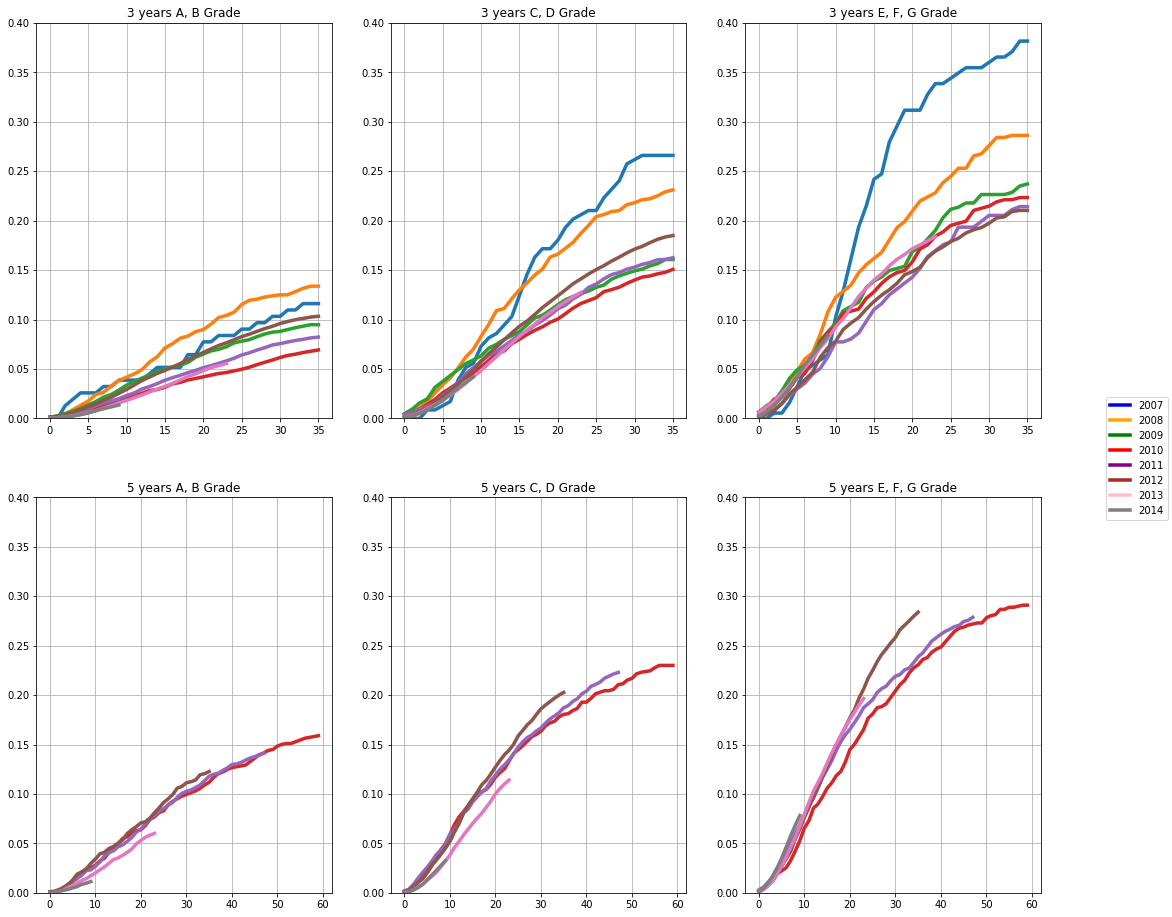

In [10]:
def calc_p_bad(vintage, period, total):
    '''
    for a given vintage calculate the percentage of loans whose last
    payment date was before loan maturity, and the loan status was not
    fully paid or current.  ASSUMPTION: these reflect non-performing
    loans
    '''
    if (total == 0):
        return np.NAN

    return (
        ((
            (
                vintage.last_pymnt_d < (
                    vintage.issue_d + pd.DateOffset(months = period)
                )
            ) | (
                vintage.last_pymnt_d.isnull()
            )
        ) & (
            vintage.loan_status.isin([
                "Charged Off",
                "Default",
                "Does not meet the credit policy. Status:Charged Off",
            ])
        )).sum() / total)

def make_vintages_plot(df):
    '''
    compare p-bad rates for loans originated in different quarters from
    2007-6-1 to 2015-1-1.  We want at least a 1-year period to see if the
    loan performs.  NOTE: despite accounting for 8 of the 9 years of historical
    data, this only captures about half of the loans in the data set.
    '''

    def make_subplot(df, term, periods, ax_handle, title):
        
        for i in range(len(vintage_intervals)-1):
            start_date = vintage_intervals[i]
            stop_date = vintage_intervals[i+1]
            vintage = df[(df.issue_d >= start_date)
                            & (df.issue_d < stop_date)] 
            total = vintage.shape[0]

                
            p_bads = []
            for n in range(1, term + 1):
                if((stop_date + relativedelta(months=n)) > LAST_PAYMENT_DATE):
                    break
                p_bad = calc_p_bad(vintage, n, total)
                p_bads.append(p_bad)
            ax_handle.plot(p_bads, linewidth=3.5)
            ax_handle.set_title(title)
  

        return(ax_handle)


    vintage_intervals = [
        dt.date(2008,1,1) + relativedelta(months=x) for x in range(0,91,12) #91
    ]
    vintage_intervals.insert(0, dt.date(2007,6,1))
    vintage_intervals[-1] += relativedelta(days=1, months=1)

    fig, ((ax_1, ax_2, ax_3),(ax_4, ax_5, ax_6)) = plt.subplots(2,3, figsize=(18, 16))

    tranch_1_3year = df[df.grade.isin(['A', 'B']) & (df.term == 36)]
    tranch_2_3year = df[df.grade.isin(['C', 'D']) & (df.term == 36)]
    tranch_3_3year = df[df.grade.isin(['E', 'F', 'G']) & (df.term == 36)]
    
    tranch_1_5year = df[df.grade.isin(['A', 'B']) & (df.term == 60)]
    tranch_2_5year = df[df.grade.isin(['C', 'D']) & (df.term == 60)]
    tranch_3_5year = df[df.grade.isin(['E', 'F', 'G']) & (df.term == 60)]

    ax_1 = make_subplot(tranch_1_3year, 36,
                        vintage_intervals, ax_1,
                        "3 years A, B Grade")
    ax_1.set_ylim([0, .4])
    ax_1.grid()

    ax_2 = make_subplot(tranch_2_3year, 36,
                        vintage_intervals, ax_2,
                        "3 years C, D Grade")  
    ax_2.set_ylim([0, .4])
    ax_2.grid()
    
    ax_3 = make_subplot(tranch_3_3year, 36,
                        vintage_intervals, ax_3,
                        "3 years E, F, G Grade")  
    ax_3.set_ylim([0, .4])
    ax_3.grid()

    ax_4 = make_subplot(tranch_1_5year, 60,
                        vintage_intervals, ax_4,
                        "5 years A, B Grade")  
    ax_4.set_ylim([0, .4])
    ax_4.grid()

    ax_5 = make_subplot(tranch_2_5year, 60,
                        vintage_intervals, ax_5,
                        "5 years C, D Grade")  
    ax_5.set_ylim([0, .4])
    ax_5.grid()

    ax_6 = make_subplot(tranch_3_5year, 60,
                        vintage_intervals, ax_6,
                        "5 years E, F, G Grade")  
    ax_6.set_ylim([0, .4])
    ax_6.grid()

    line_handles = [
        mlines.Line2D([], [], color='blue', linewidth=3.5, label='2007'),
        mlines.Line2D([], [], color='orange', linewidth=3.5, label='2008'),
        mlines.Line2D([], [], color='green', linewidth=3.5, label='2009'),
        mlines.Line2D([], [], color='red', linewidth=3.5, label='2010'),
        mlines.Line2D([], [], color='purple', linewidth=3.5, label='2011'),
        mlines.Line2D([], [], color='brown', linewidth=3.5, label='2012'),
        mlines.Line2D([], [], color='pink', linewidth=3.5, label='2013'),
        mlines.Line2D([], [], color='grey', linewidth=3.5, label='2014')
    ]  
    
    #plt.legend(handles=line_handles)
    fig.legend(line_handles, ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'], 'right')
    
    plt.show()

make_vintages_plot(enriched_data)


In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error

#only model 3 year loans with full payment histories.  That restricts universe to issue dates before 2013-1-1
def add_features_post_split(df):
    '''
    these features considered population-level statistics and thus need to be added after train-test splits
    '''
    def zscore(s):
        return (s - s.mean()) / s.std()
    
    df['zscore_income_by_grade'] = df.groupby([df.grade])['annual_inc'].transform(zscore)
    df.zscore_income_by_grade = df.zscore_income_by_grade.fillna(
        df.zscore_income_by_grade.median()
    )
    df['zscore_int_rate_by_grade'] = df.groupby([df.grade])['int_rate'].transform(zscore)
    df.zscore_int_rate_by_grade = df.zscore_int_rate_by_grade.fillna(
        df.zscore_int_rate_by_grade.median()
    )
    df['zscore_int_rate_by_purpose'] = df.groupby([df.purpose])['int_rate'].transform(zscore)
    df.zscore_int_rate_by_purpose = df.zscore_int_rate_by_purpose.fillna(
        df.zscore_int_rate_by_purpose.median()
    )
    df['zscore_dti_by_grade'] = df.groupby([df.grade])['dti'].transform(zscore)
    df.zscore_dti_by_grade = df.zscore_dti_by_grade.fillna(
        df.zscore_dti_by_grade.median()
    )
    
    return df

def prepare_modeling(df):
    scaler = MinMaxScaler()
    
    df = add_features_post_split(df)
    dummy_cols = [
        'home_ownership', 'verification_status', 'grade', 'sub_grade', 'purpose', 'initial_list_status'
    ]
    df = pd.get_dummies(df, columns=dummy_cols)
    df['issue_days_since_start'] = (df.issue_d - EARLIEST_ISSUE).dt.days
    df = df.drop(['loan_amnt', 'issue_d', 'loan_status', 'zip_code', 'addr_state', 'earliest_cr_line',
                 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
                 'total_rec_int','total_rec_int','total_rec_late_fee','recoveries',
                 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
                 'last_credit_pull_d', 'loan_is_open', 'maturity_d', 'loan_duration', 'raw_ROI',
                 'raw_rel_yield','yearly_rel_yield', 'issue_d_year'], axis=1)
    df[df.columns] = scaler.fit_transform(df[df.columns])
    df_x = df.loc[:, df.columns != 'yearly_ROI']
    df_y = df.yearly_ROI.values
    #df_x = df.loc[:, df.columns != 'yearly_ROI']
    #df_x[df_x.columns] = scaler.fit_transform(df_x[df_x.columns])
    #df_y = df.yearly_ROI.values*100
    #df_y = df_y.reshape(df_y.shape[0],1)
    return df_x, df_y

    

    
def split(df, start_time=dt.date(2009,1,1), end_time=dt.date(2011,1,1)):
    
    df = df[~df.loan_is_open]
    df = df[df.issue_d >= start_time]
    df = df[df.issue_d < end_time]
    df = df[df.term == 36]
     
    
    train, test = train_test_split(df, test_size=0.2)
    
    train_x, train_y = prepare_modeling(train)
    test_x, test_y = prepare_modeling(test)
        
    return ((train_x, train_y), (test_x, test_y))

#enriched_data.describe(include='all')
((train_x, train_y), (test_x, test_y)) = split(enriched_data)
display(train_y)
clf = linear_model.Ridge(alpha=0.1)
clf.fit(train_x, train_y)
pred = clf.predict(test_x)
#train_x['y'] = train_y
#train_x['y_pred'] = pred
test_x['y'] = test_y
test_x['y_pred'] = pred
print(mean_absolute_error(test_y,pred))
display(test_x)


#print(clf.coef_)


#test.loc[test.index[pd.isnull(test).any(1)]]

/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/peter/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

array([0.89507238, 0.89021827, 0.89401882, ..., 0.91792933, 0.87605194,
       0.8901145 ])

0.06487090678815706


,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,emp_length_imp,earliest_cr_delta,revol_limit,avg_revol_acc_limit,avg_revol_acc_bal,percentage_funded,inst_to_income,zscore_income_by_grade,zscore_int_rate_by_grade,zscore_int_rate_by_purpose,zscore_dti_by_grade,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,grade_G,grade_F,grade_E,grade_D,grade_C,grade_B,grade_A,sub_grade_G5,sub_grade_G4,sub_grade_G3,sub_grade_G2,sub_grade_G1,sub_grade_F5,sub_grade_F4,sub_grade_F3,sub_grade_F2,sub_grade_F1,sub_grade_E5,sub_grade_E4,sub_grade_E3,sub_grade_E2,sub_grade_E1,sub_grade_D5,sub_grade_D4,sub_grade_D3,sub_grade_D2,sub_grade_D1,sub_grade_C5,sub_grade_C4,sub_grade_C3,sub_grade_C2,sub_grade_C1,sub_grade_B5,sub_grade_B4,sub_grade_B3,sub_grade_B2,sub_grade_B1,sub_grade_A5,sub_grade_A4,sub_grade_A3,sub_grade_A2,sub_grade_A1,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,issue_days_since_start,y,y_pred
23713,0.358333,0.367556,0.0,0.457379,0.323093,0.0,0.034785,0.805122,0.000000,0.000000,1.000000,0.066667,0.0,0.039496,0.874875,0.125000,0.0,0.0,0.0,0.236634,0.002580,0.003667,0.074527,1.000000,0.186903,0.061448,0.741157,0.457379,0.738780,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957082,0.898732,0.875489
32391,0.125000,0.137577,0.0,0.630407,0.120563,0.5,0.015571,0.364946,0.000000,0.111111,1.000000,0.200000,0.0,0.005213,0.491491,0.109375,0.0,0.0,0.0,0.132772,0.000606,0.000431,0.004918,1.000000,0.165022,0.027353,0.859935,0.630407,0.337725,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566524,0.034347,0.849445
29202,0.208333,0.217024,0.0,0.409669,0.186725,1.0,0.045658,0.314926,0.000000,0.000000,1.000000,0.166667,0.5,0.011901,0.582583,0.156250,0.0,0.0,0.0,0.132595,0.001168,0.000948,0.012832,0.988065,0.089165,0.073873,0.894153,0.467215,0.327700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.738197,0.895950,0.866026
35762,0.229167,0.232033,0.0,0.496183,0.209849,1.0,0.030087,0.369348,0.000000,0.000000,0.007101,0.200000,0.0,0.009541,0.446446,0.140625,0.0,0.0,0.0,0.216851,0.001221,0.000868,0.009002,0.966346,0.145619,0.055176,0.809554,0.558496,0.338913,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303290,0.929603,0.877917
36198,0.375000,0.371663,0.0,0.164122,0.313874,1.0,0.019794,0.502601,0.000000,0.111111,1.000000,0.300000,0.0,0.010013,0.215215,0.546875,0.0,0.0,0.0,0.410386,0.002659,0.001374,0.006870,0.967188,0.302959,0.045424,0.855165,0.164122,0.554712,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [152]:
full_data = enriched_data.iloc[test_x.index]
full_data['y_pred'] = pred
print(full_data.shape)
good = full_data.loc[full_data.y_pred > .88]
print(good.shape)
print((full_data.total_pymnt.sum() - full_data.funded_amnt.sum()) / full_data.funded_amnt.sum())
print((good.total_pymnt.sum() - good.funded_amnt.sum()) / good.funded_amnt.sum())

(2888, 59)
(743, 59)
0.08880932916003136
0.10166752228011999


/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
model_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'issue_d', 'loan_status',
       ...
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'initial_list_status_f',
       'initial_list_status_w'],
      dtype='object', length=119)